In [1]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,18 mins 10 secs
H2O_cluster_timezone:,America/Asuncion
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 28 days
H2O_cluster_name:,H2O_from_python_davidnunez_l72caj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.780 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [1]:
import pandas as pd
balanced_df = pd.read_csv('../balanced_output.csv', index_col=False)
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)

In [16]:
balanced_df.shape

(63286, 932)

In [18]:
df_c = balanced_df[balanced_df['Protestas'] == True]
df_c.shape

(10547, 932)

In [3]:
train = h2o.H2OFrame.from_python(train_data)
test = h2o.H2OFrame.from_python(test_data)
# Identify predictors and response
y = "Protestas"
x = train.columns
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=25, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leader
# board
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
23:28:48.84: AutoML: XGBoost is not available; skipping it.
23:28:48.90: _train param, Dropping bad and constant columns: [contracts.investmentProjects.id_8, contracts.investmentProjects.id_37, parties.details.legalEntityTypeDetail buyer_15, parties.details.legalEntityTypeDetail buyer_14, parties.details.legalEntityTypeDetail buyer_13, parties.details.legalEntityTypeDetail buyer_12, parties.details.legalEntityTypeDetail buyer_11, parties.details.legalEntityTypeDetail buyer_10, parties.details.EntityType payee_1, parties.details.EntityType payee_2, parties.details.EntityType payee_3, parties.details.EntityType payee_4, planning.items.classification.id.n1_1_56, planning.items.classification.id.n1_1_57, contracts.investmentProjects.id_102, contracts.investmentProjects.id_100, Monto faltante, parties.details.legalEntityTypeDetail notifiedSupplier_18, tender.status_active, contracts.investmentProjects.id_17, tender.statusDetails_En Convocatoria (Abierta), parties.details.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_3_20230726_232848,0.966787,0.131702,0.924213,0.109927,0.186584,0.0348136
StackedEnsemble_BestOfFamily_1_AutoML_3_20230726_232848,0.965324,0.135191,0.921117,0.109275,0.188936,0.0356968
GBM_grid_1_AutoML_3_20230726_232848_model_5,0.964329,0.139035,0.920177,0.113106,0.18949,0.0359065
GBM_grid_1_AutoML_3_20230726_232848_model_4,0.96361,0.13842,0.919576,0.112126,0.189298,0.0358337
GBM_1_AutoML_3_20230726_232848,0.962492,0.140477,0.916724,0.112714,0.191492,0.0366691
GBM_grid_1_AutoML_3_20230726_232848_model_1,0.962224,0.140569,0.917744,0.111825,0.190029,0.0361111
GBM_4_AutoML_3_20230726_232848,0.961687,0.140749,0.916247,0.112489,0.191434,0.036647
GBM_3_AutoML_3_20230726_232848,0.960411,0.143299,0.913151,0.115697,0.194077,0.0376659
GBM_2_AutoML_3_20230726_232848,0.960223,0.144459,0.912114,0.110191,0.195303,0.0381431
GBM_grid_1_AutoML_3_20230726_232848_model_6,0.955663,0.16403,0.893386,0.133169,0.211655,0.0447978


In [7]:
aml.leader

key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/25
# GBM base models (used / total),6/12
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
# DeepLearning base models (used / total),1/10
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [8]:
preds = aml.predict(test)
# preds = aml.leader.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [9]:
preds['predict'] == 'True'
preds_True = preds[(preds['predict'] == 'True')]
preds_True.head(50)

predict,False,True
True,0.00904625,0.990954
True,0.00580743,0.994193
True,0.0014758,0.998524
True,0.00163797,0.998362
True,0.011334,0.988666
True,0.00390976,0.99609
True,0.209709,0.790291
True,0.0766781,0.923322
True,0.0666025,0.933398
True,0.0411318,0.958868


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_3_20230726_232848,0.968291,0.125171,0.933934,0.102267,0.180125,0.0324452,10503,0.053706,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_3_20230726_232848,0.966407,0.128204,0.931152,0.0988129,0.181805,0.0330529,7511,0.012925,StackedEnsemble
GBM_grid_1_AutoML_3_20230726_232848_model_4,0.96618,0.132141,0.929438,0.101585,0.18352,0.0336797,87168,0.009189,GBM
GBM_grid_1_AutoML_3_20230726_232848_model_5,0.965628,0.130261,0.931183,0.100774,0.18129,0.032866,38735,0.006642,GBM
GBM_1_AutoML_3_20230726_232848,0.965136,0.134088,0.927998,0.101633,0.186218,0.0346772,92130,0.012802,GBM
GBM_grid_1_AutoML_3_20230726_232848_model_1,0.96463,0.133945,0.927257,0.0980751,0.184699,0.0341137,94837,0.006992,GBM
GBM_4_AutoML_3_20230726_232848,0.964438,0.13301,0.927421,0.0981939,0.184905,0.03419,86566,0.011531,GBM
GBM_3_AutoML_3_20230726_232848,0.963664,0.137642,0.923601,0.105342,0.189366,0.0358596,87153,0.016008,GBM
GBM_2_AutoML_3_20230726_232848,0.963069,0.1397,0.921727,0.108462,0.191311,0.0365999,109586,0.015663,GBM
GBM_grid_1_AutoML_3_20230726_232848_model_6,0.957637,0.162163,0.902521,0.115027,0.209391,0.0438447,15613,0.012073,GBM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_3_20230726_232848

,False,True,Error,Rate
False,10424.0,63.0,0.006,(63.0/10487.0)
True,431.0,1740.0,0.1985,(431.0/2171.0)
Total,10855.0,1803.0,0.039,(494.0/12658.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

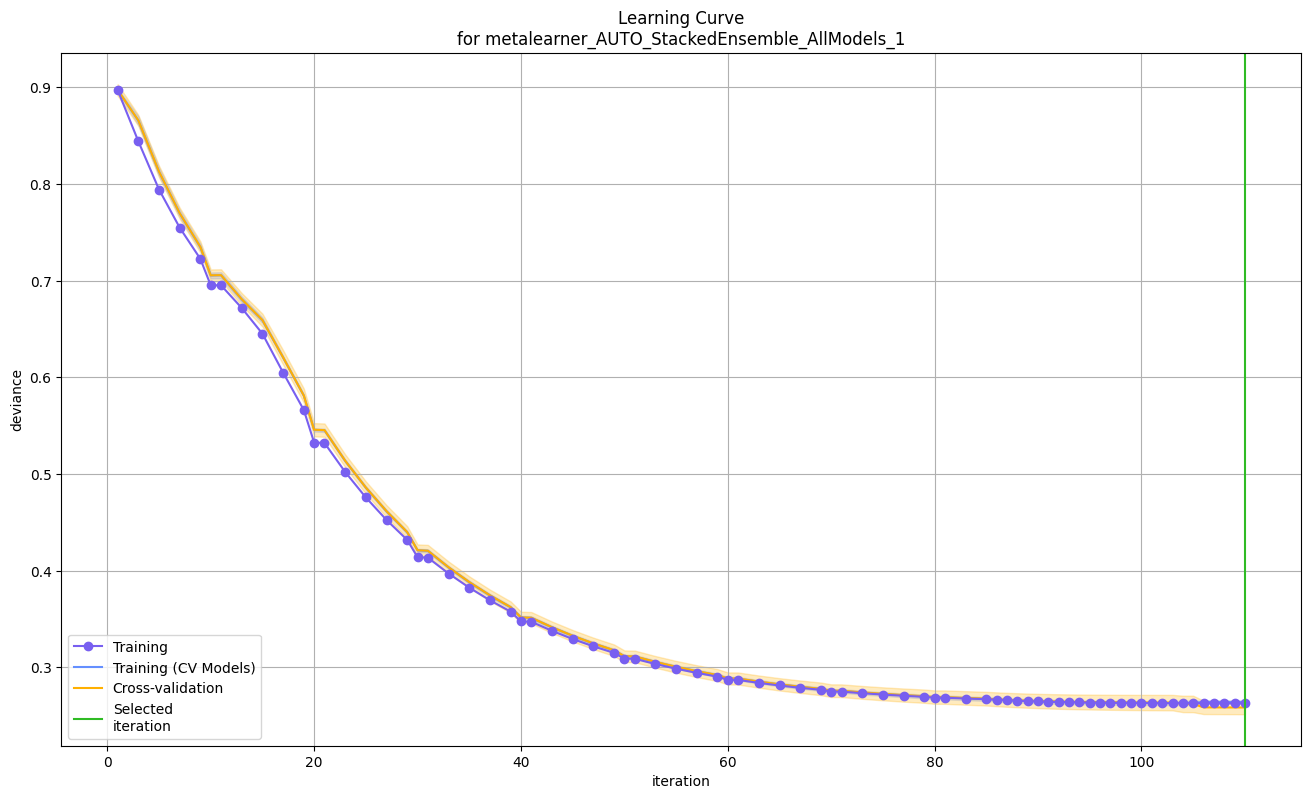

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

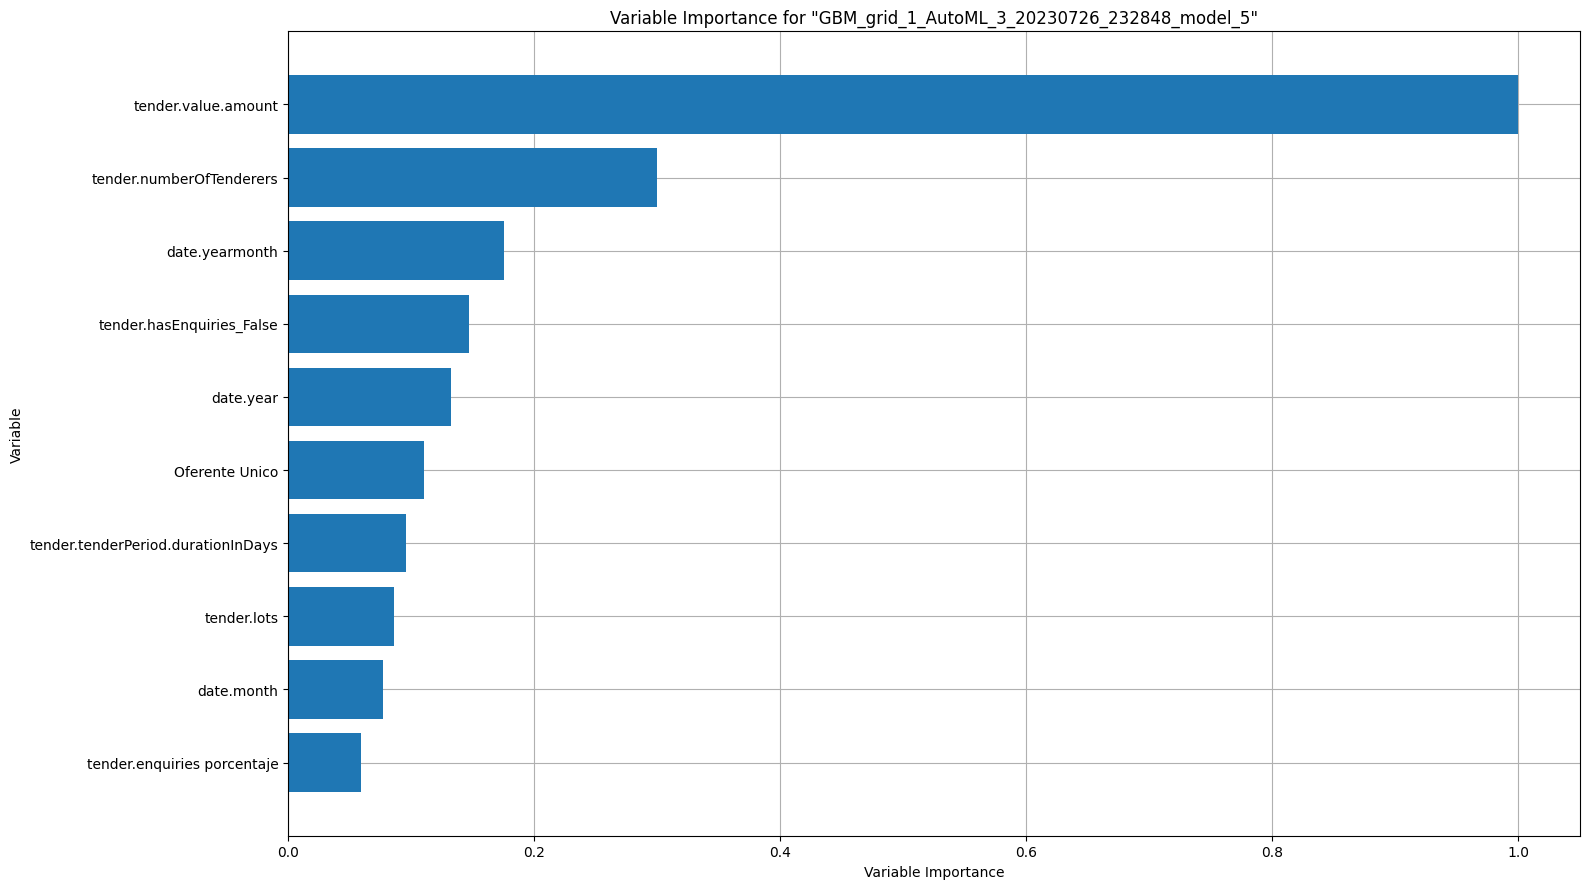

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

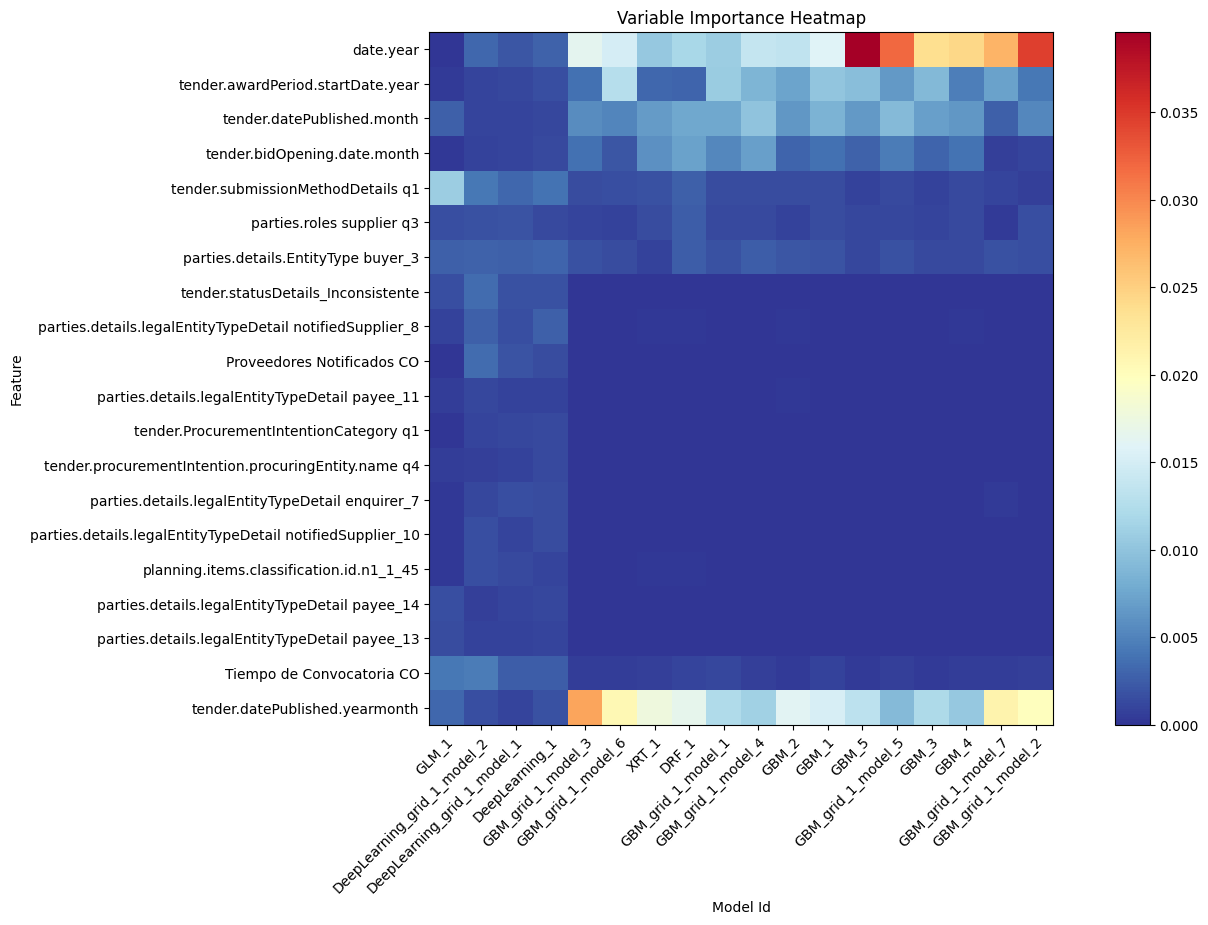

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

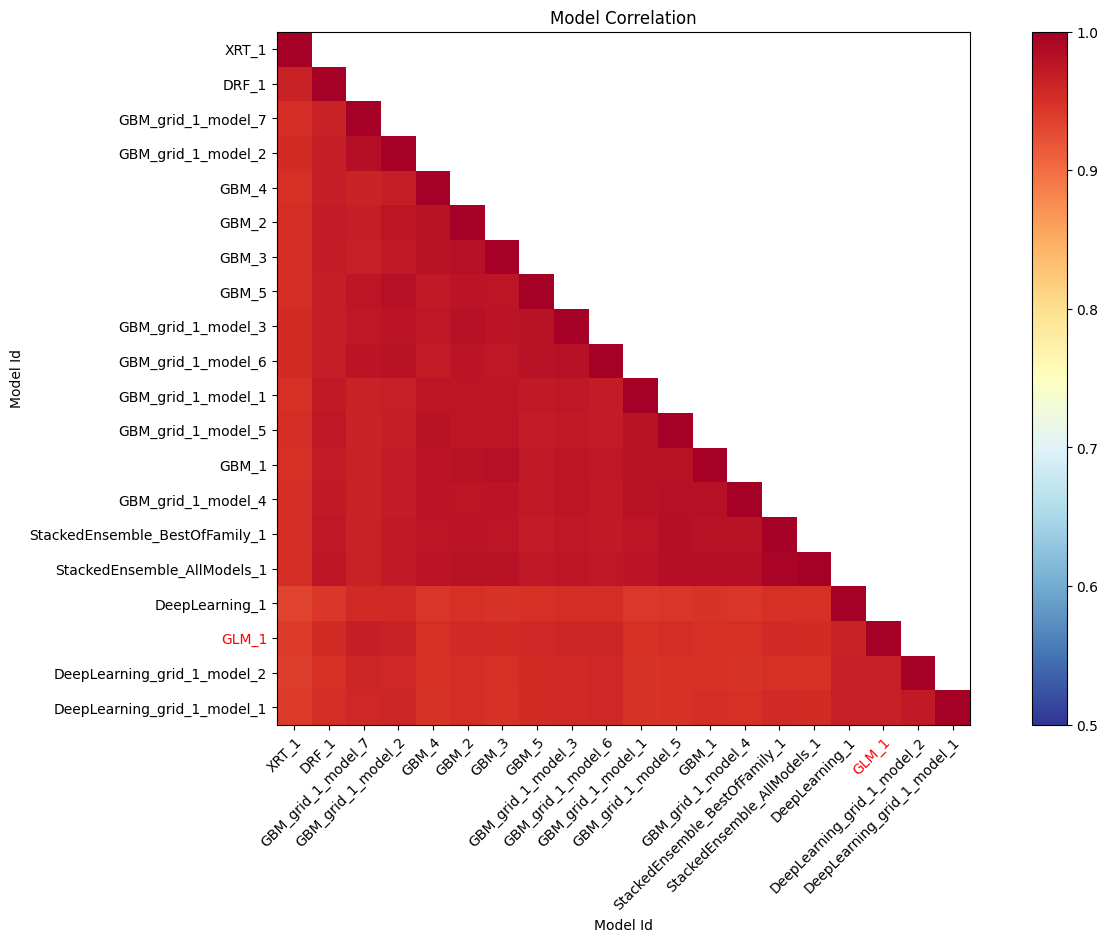

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

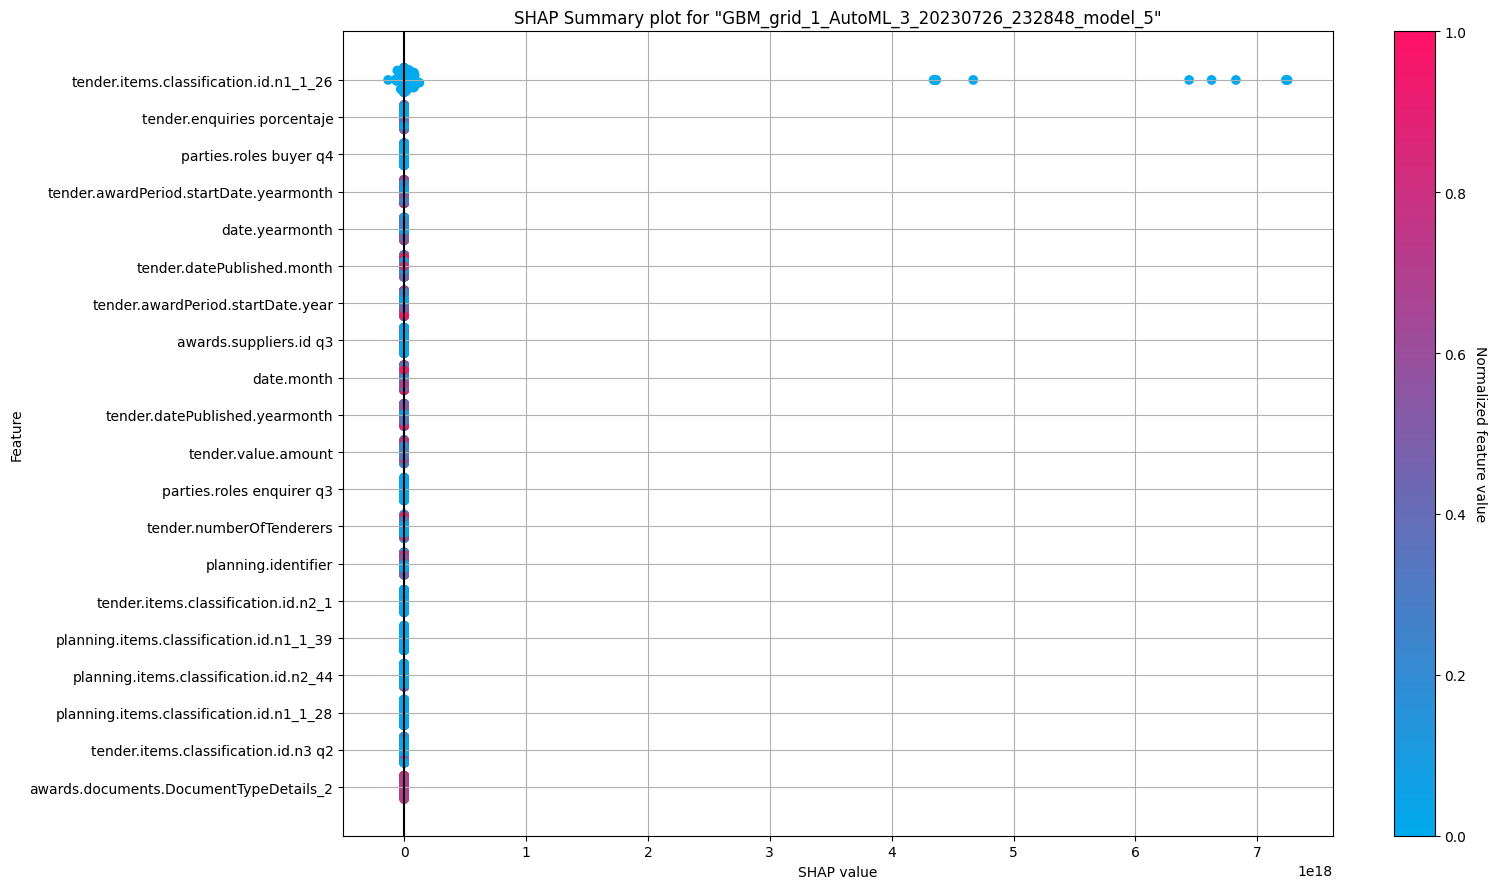

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

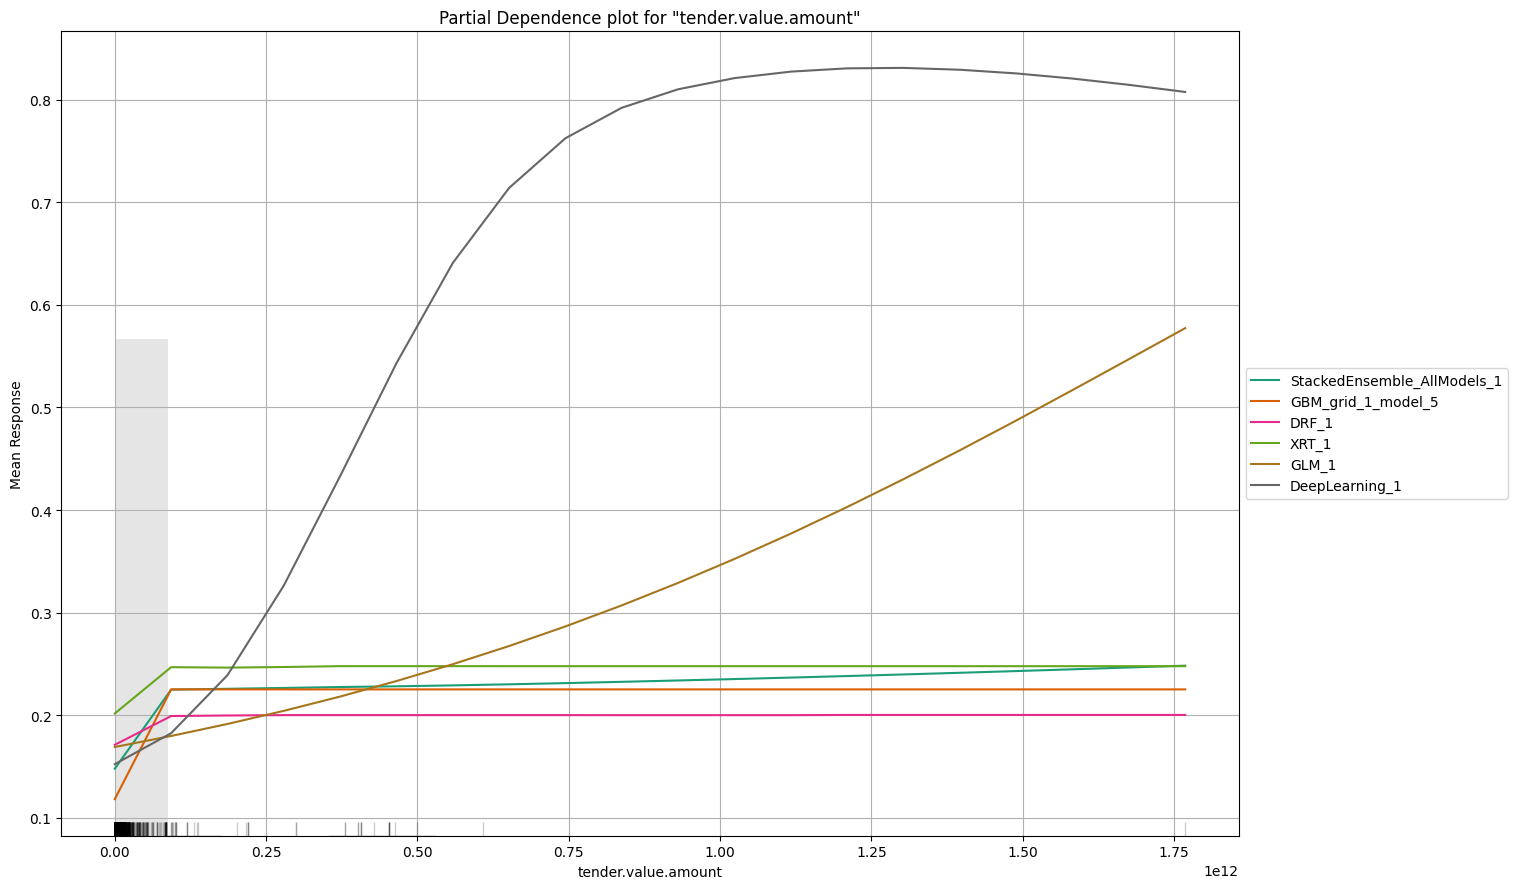

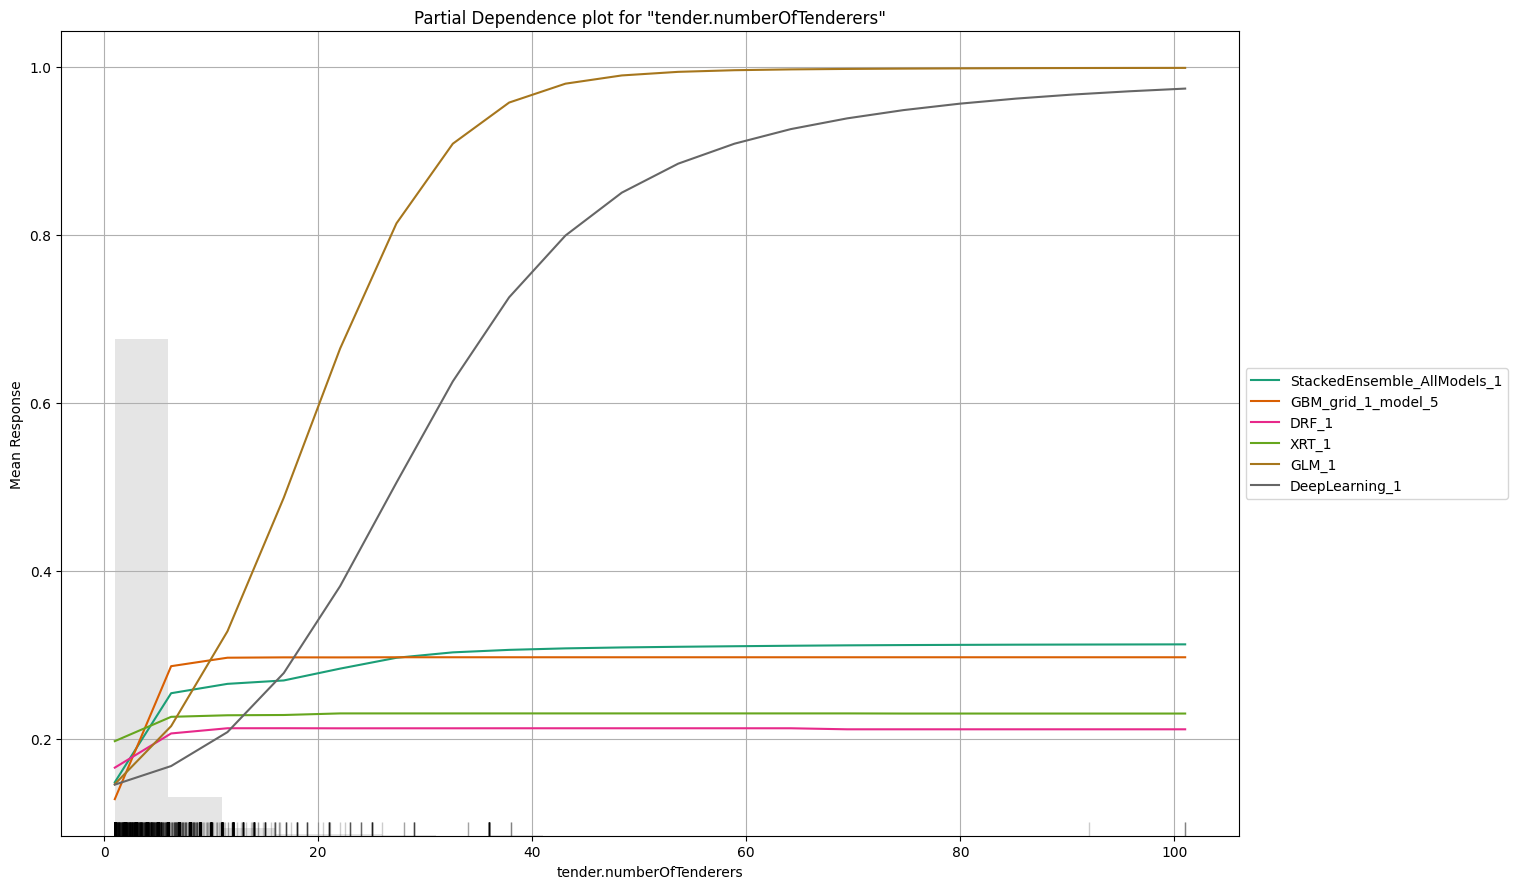

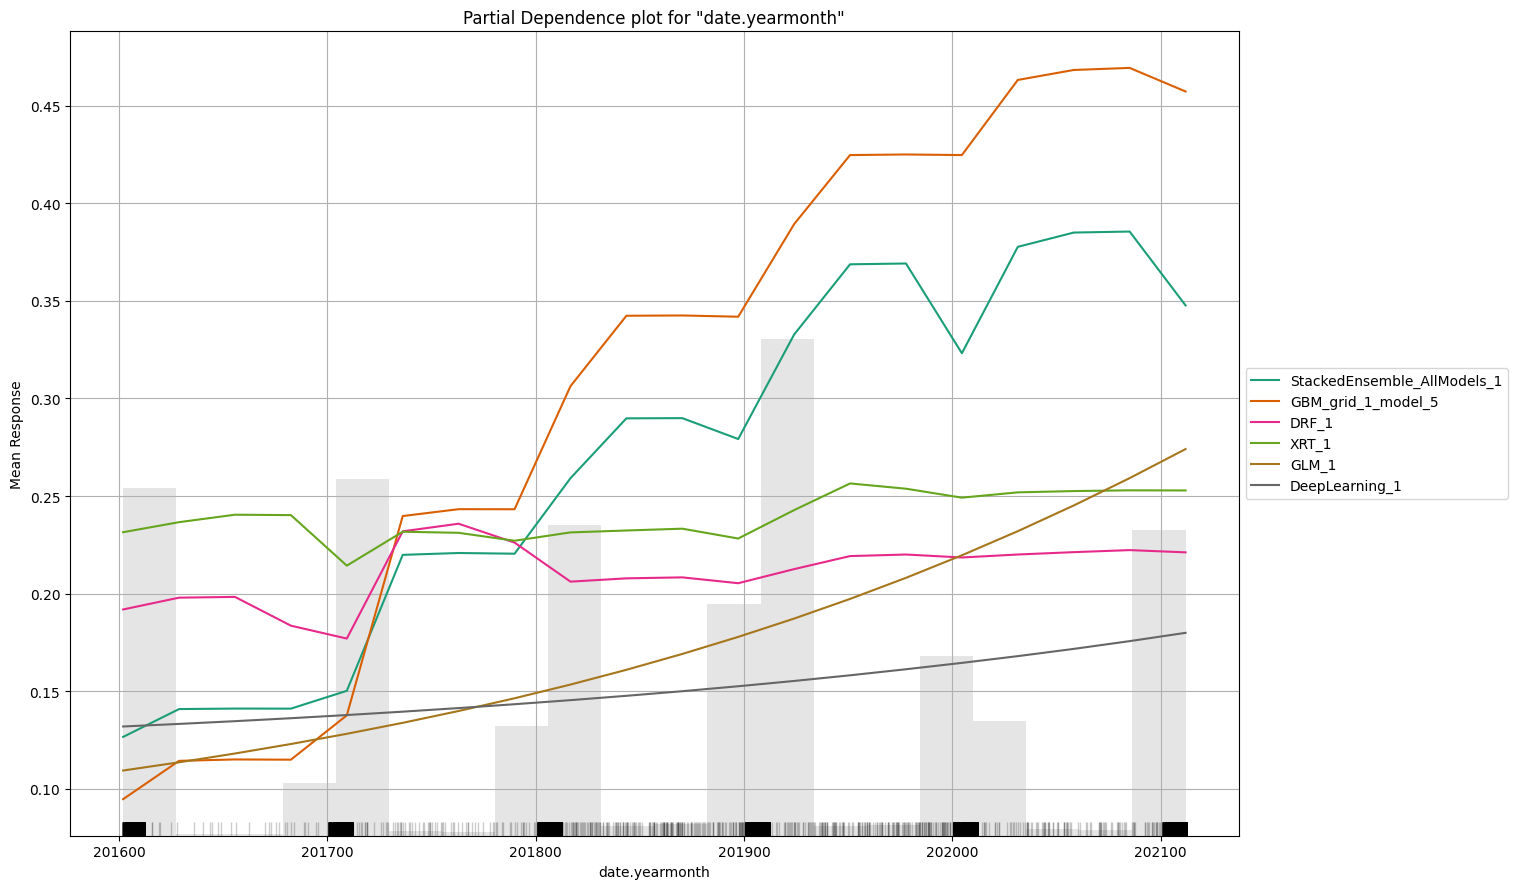

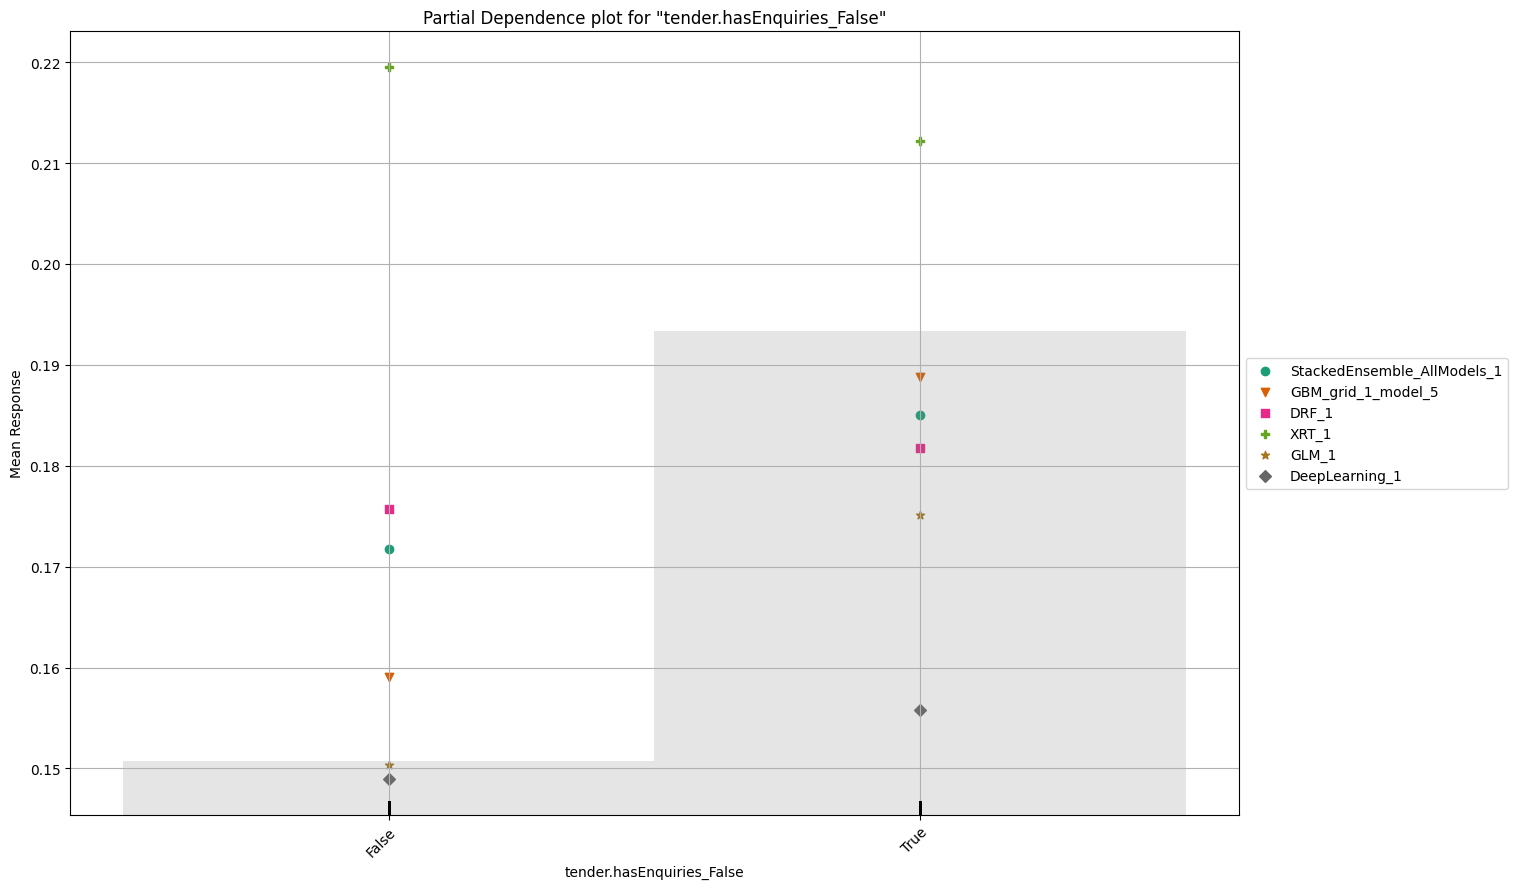

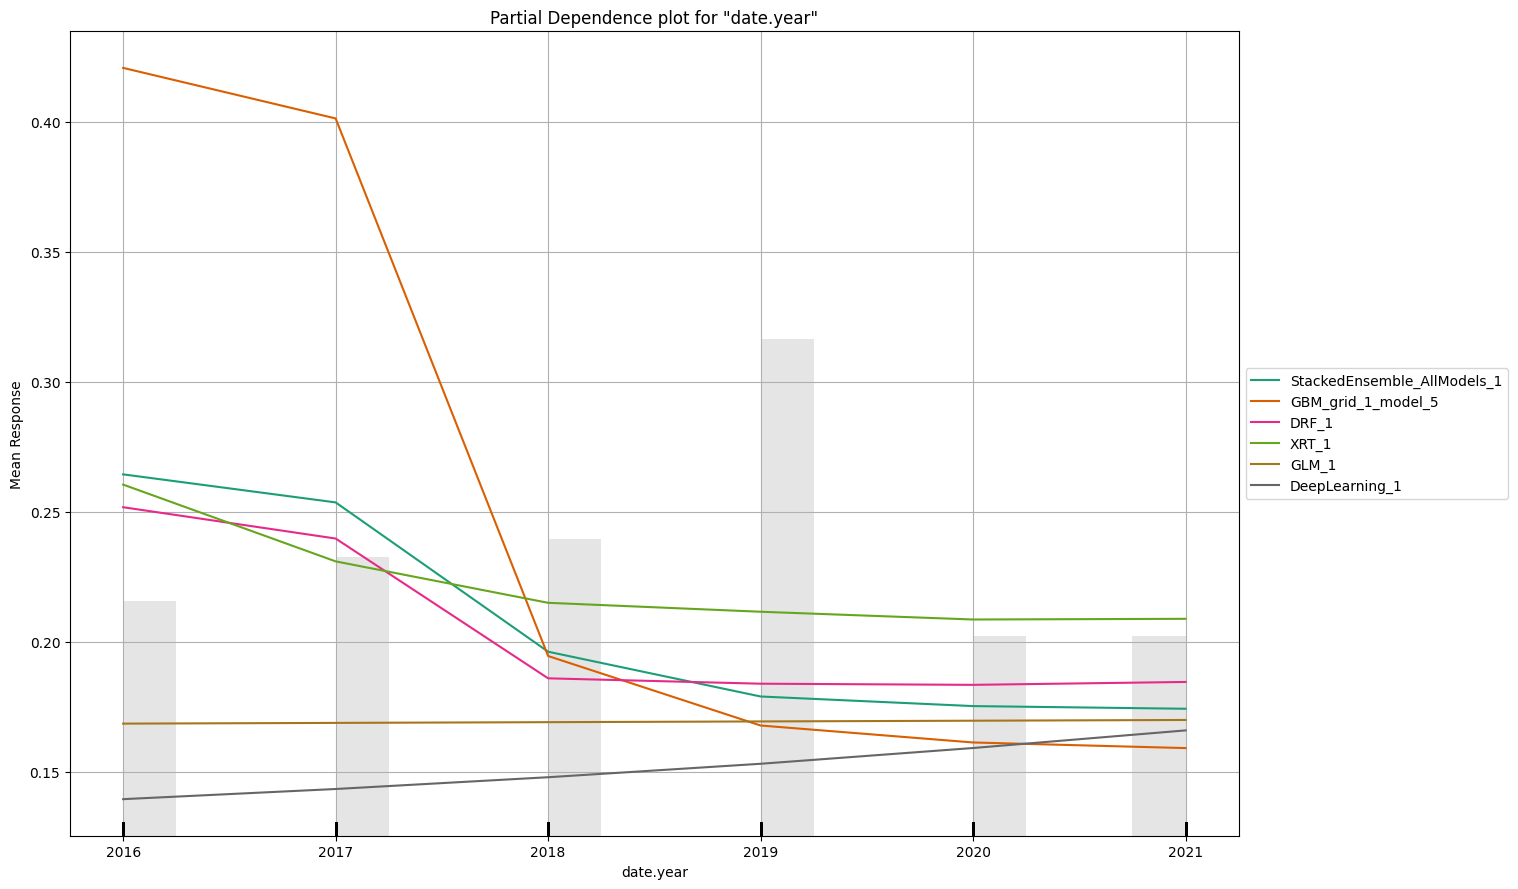

In [10]:
exa = aml.explain(test)

In [11]:
model_path = h2o.save_model(model=aml.leader, path="train2021/smoteModel", force=True)

In [13]:
print(model_path)

/Users/davidnunez/Desktop/tesis/tesis-model/Training/tmp/initialModel/StackedEnsemble_AllModels_1_AutoML_3_20230703_231559


In [ ]:
saved_model = h2o.load_model(model_path)

## Testing 2022 Data

In [12]:
df_2022 = pd.read_csv('../df_dummizado_from_2021.csv', index_col=False)
df_2022 = df_2022[df_2022['date.year'] == 2022]
test = h2o.H2OFrame.from_python(df_2022)
test[y] = test[y].asfactor()
preds2022 = aml.predict(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [13]:
df_preds = preds2022.as_data_frame()
df_preds['result'] = df_preds['True'] >= 0.5
df_preds['is_right'] = df_preds['result'] == df_preds['predict']
# df_preds.head()
# GROUP BY 
gkk = df_preds.groupby(['is_right'], dropna=False)
gkk.count()

,predict,False,True,result
is_right,,,,
False,42,42,42,42
True,21942,21942,21942,21942


In [14]:
df_preds.shape

(21984, 5)

In [15]:
print('Acerto', 100*21942/21984)

Acerto 99.8089519650655
